# H12 signal detection

when runing the I begun with the 2rl xsome and then edited both this and h12 signal detections notebooks. so if one needs to run same analysis they would have to run it say 3 times for the 3 funestus chromosome arms . the current version is for th x chromosome that I have run last


I am deleting the first .yaml file because for some reason the code fails to verwite the exsisting file 



## Setup

In [1]:
!pip install dask_
!pip install lmfit
!pip install pyprojroot


Defaulting to user installation because normal site-packages is not writeable
ERROR: Invalid requirement: 'dask_'
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import yaml
import pandas as pd
import malariagen_data
from pyprojroot import here
import numpy as np
import os
import dask
dask_scheduler = 'threads'
dask.config.set(scheduler=dask_scheduler);
import matplotlib.pyplot as plt
from bisect import bisect_left, bisect_right
import lmfit
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%run /home/namulil/lstm_projects/funestus_llineup/notebooks/Signal_localisation/peak-utils_21.jan.25.ipynb

/home/namulil/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
af1 = malariagen_data.Af1(pre=True,
                          gcs_cache='/home/namulil/lstm_projects/funestus_llineup/gcs_cache',
                          results_cache='home/namulil/lstm_projects/funestus_llineup/results_cache'
                          )

In [8]:
## Do PCA --output is df with PCA results and and array of explained variance
sample_sets = ["1288-VO-UG-DONNELLY-VMF00219"]
sample_query = "sex_call == 'F'"
region = '3RL'
n_snps = 100_000

pca_3RL_df, evr = af1.pca(region=region, n_snps=n_snps, sample_sets=sample_sets,sample_query=sample_query)

In [ ]:
## checking if my df has values/ was created
pca_3RL_df

In [ ]:
##pulling out PC1 to see if I have any values in it
pca_3RL_df['PC1']

In [ ]:
## trying to create a df for the values below -50 by filtering out where bolean is true
mask_values=pca_3RL_df[pca_X_df['PC1']< -50]
mask_values

In [ ]:
standard = pca_3RL_df.loc[pca_3RL_df['PC1'] < -50, 'sample_id'].tolist()## filter out rows with PCA less than 50 and select according to smaple id

In [ ]:
standard

In [4]:
# Notebook parameters. Values here are for development only and 
# will be overridden when running via snakemake and papermill.
# cohort_id = 'CD-NU_Gbadolite_gamb_2015_Q3'
cohort_id = 'llineup'
#cohorts_analysis = "20230223"
contig = '3RL'
#sample_query = f"sample_id in {standard}"
min_cohort_size = None
max_cohort_size = None
use_gcs_cache = False
dask_scheduler = "threads"
h12_signal_detection_min_delta_aic = 500
h12_signal_detection_min_stat_max = 0.1
h12_signal_detection_gflanks = [6]

In [5]:
# load window sizes from output of h12-calibration
calibration_dir = "/home/namulil/lstm_projects/funestus_llineup/notebooks/Signal_localisation/"
calibration_file_path = f"{calibration_dir}{cohort_id}.yaml"
with open(calibration_file_path, 'r') as calibration_file:
    calibration_params = yaml.safe_load(calibration_file)
window_size = calibration_params["h12_window_size"]
window_size

500

## Run signal detection

In [6]:
# set parameters for signal detection
filter_size = 20  # hampel filter parameter
filter_t = 2  # hampel filter parameter
scan_interval = 1  # step in cM
min_baseline = 0
max_baseline_percentile = 95
min_amplitude = 0.03
init_amplitude = 0.5
max_amplitude = 1.5
min_decay = 0.1
init_decay = 0.5 
max_abs_skew = 0.5
scan_start = None
scan_stop = None
# TODO maybe set false in production to avoid too many plots?
debug = True

In [9]:
# load gwss data
ppos, h12 = af1.h12_gwss(
    contig=contig, 
    window_size=window_size, 
    analysis='funestus', 
    sample_sets=sample_sets,
    sample_query=None, 
    min_cohort_size=min_cohort_size,
    max_cohort_size=max_cohort_size,
)

Access haplotypes: ⠹ (0:00:00.17) 

Load haplotypes:   0%|          | 0/576 [00:00<?, ?it/s]

In [54]:
h12

array([0.1930189 , 0.51793384, 0.57678412, ..., 0.00518488, 0.11494934,
       0.27721323])

In [11]:
# convert to int
ppos = ppos.astype(int)

In [56]:
ppos

array([   37504,   153909,   197652, ..., 22180792, 22216887, 22254718])

In [12]:
# map physical to genetic position
gpos = af_p2g(contig=contig, ppos=ppos)  

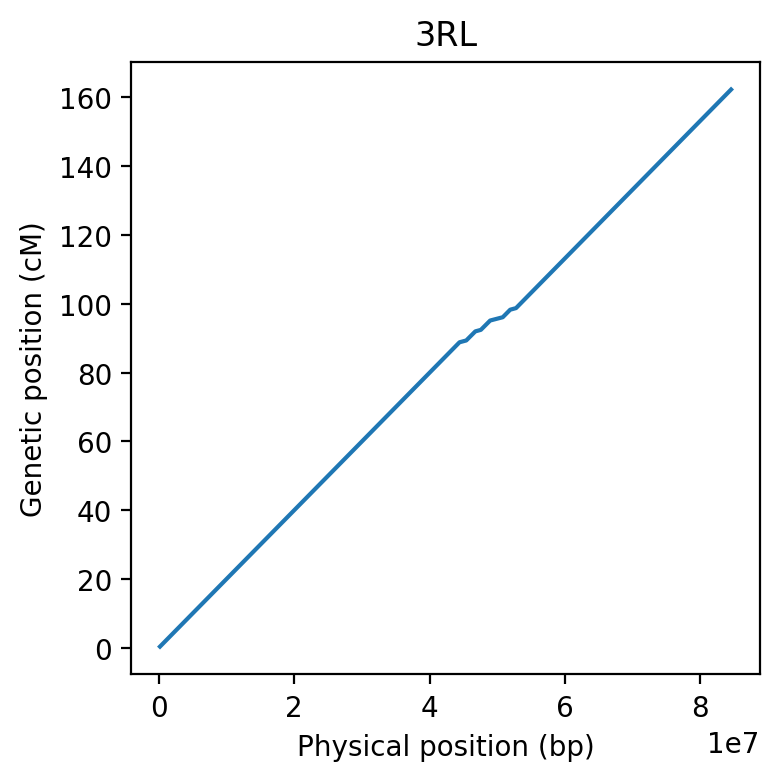

In [13]:
if debug:
    # quick check of genetic map
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(ppos, gpos)
    ax.set_xlabel('Physical position (bp)')
    ax.set_ylabel('Genetic position (cM)')
    ax.set_title(contig)
    fig.tight_layout()


In [14]:
# filter outliers
h12_filtered = hampel_filter(h12, size=filter_size, t=filter_t)

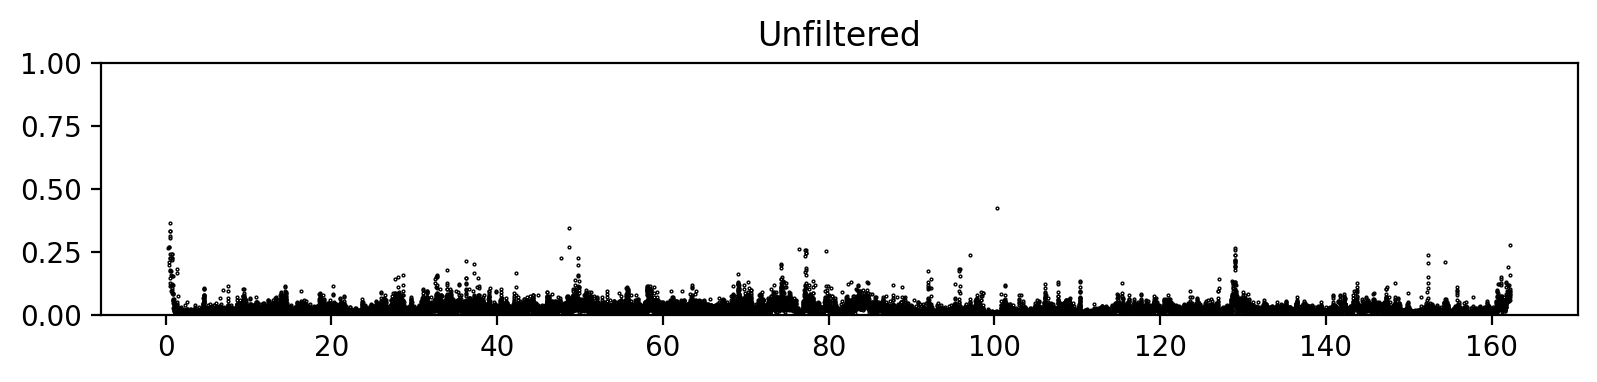

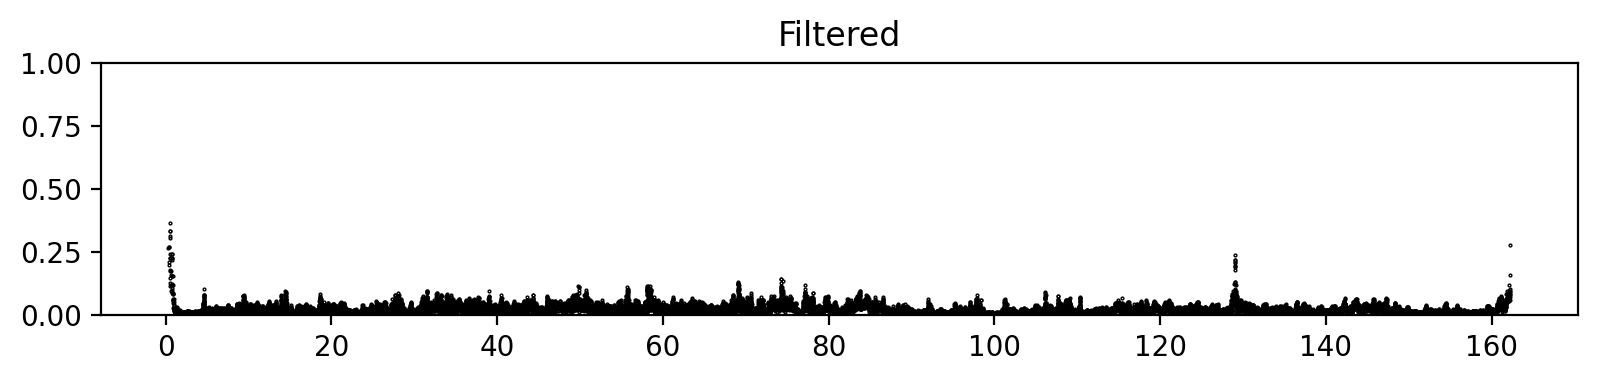

In [15]:
if debug:

    # before filtering
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(gpos, h12, marker='o', linestyle=' ', mfc='none', markersize=1, mew=.5, color='k')
    ax.set_title('Unfiltered')
    ax.set_ylim(0, 1)
    fig.tight_layout()

    # after filtering
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(gpos, h12_filtered, marker='o', linestyle=' ', mfc='none', markersize=1, mew=.5, color='k')
    ax.set_title('Filtered')
    ax.set_ylim(0, 1)
    fig.tight_layout()


In [16]:
# set parameters
init_baseline = np.median(h12_filtered)
max_baseline = np.percentile(h12_filtered, max_baseline_percentile)
min_skew, init_skew, max_skew = -max_abs_skew, 0, max_abs_skew
if not scan_start:
    scan_start = 2
if not scan_stop:
    scan_stop = gpos[-1] - 2

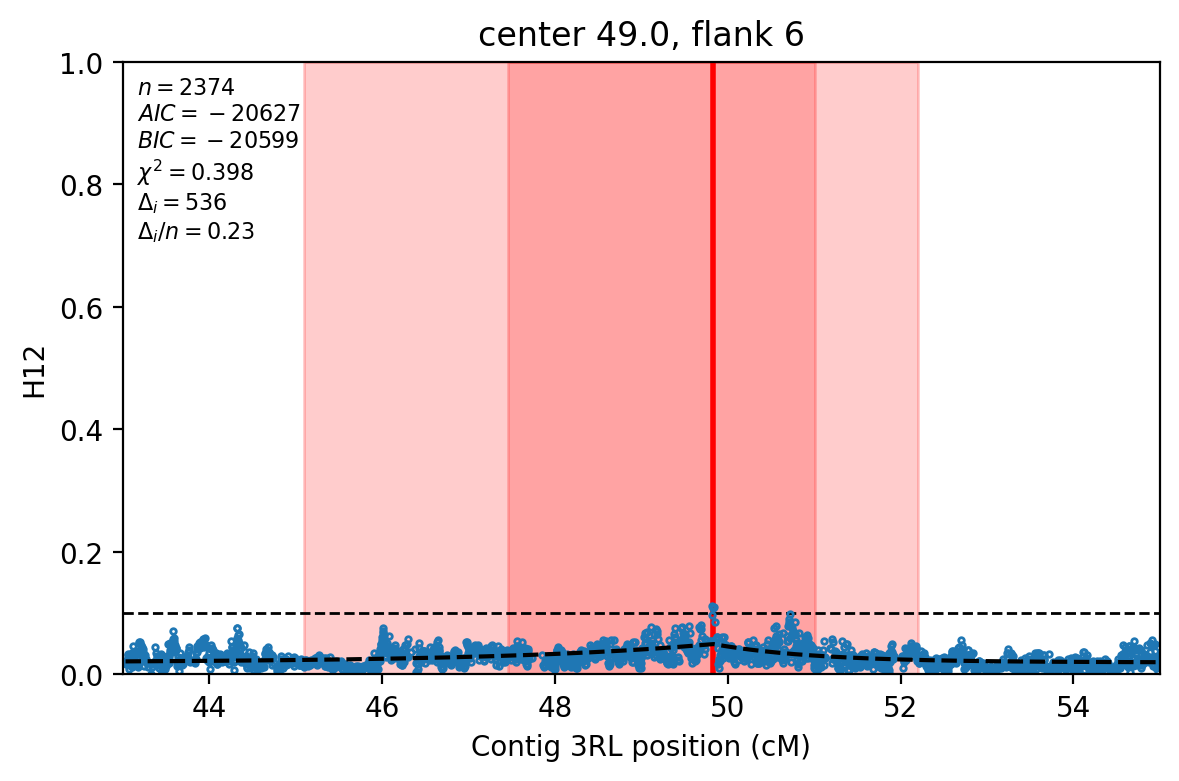

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 452
    # data points      = 2374
    # variables        = 5
    chi-square         = 0.39821930
    reduced chi-square = 1.6810e-04
    Akaike info crit   = -20627.3814
    Bayesian info crit = -20598.5197
##  Warning: uncertainties could not be estimated:
    amplitude:  at boundary
    skew:       at boundary
[[Variables]]
    center:     49.8303078 (init = 49)
    amplitude:  0.03000000 (init = 0.5)
    decay:      1.67452091 (init = 0.5)
    skew:       0.50000000 (init = 0)
    baseline:   0.01962586 (init = 0.01640945)
    ceiling:    1 (fixed)
    floor:      0 (fixed)


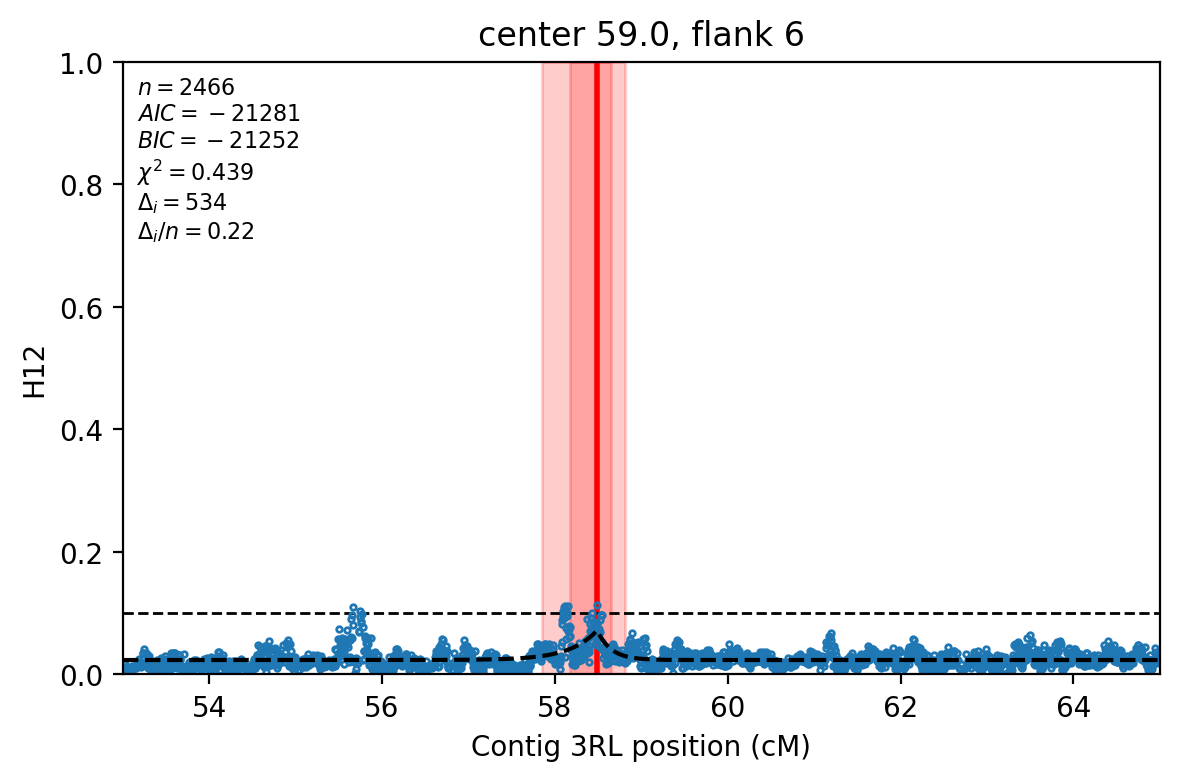

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 105
    # data points      = 2466
    # variables        = 5
    chi-square         = 0.43890690
    reduced chi-square = 1.7834e-04
    Akaike info crit   = -21281.0017
    Bayesian info crit = -21251.9499
[[Variables]]
    center:     58.4902159 +/- 0.01220764 (0.02%) (init = 59)
    amplitude:  0.04844016 +/- 0.00262160 (5.41%) (init = 0.5)
    decay:      0.22583434 +/- 0.01947471 (8.62%) (init = 0.5)
    skew:       0.49999990 +/- 0.01833455 (3.67%) (init = 0)
    baseline:   0.02354545 +/- 2.9416e-04 (1.25%) (init = 0.01640945)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = -0.685
    C(amplitude, decay) = -0.615
    C(decay, skew)      =  0.372
    C(decay, baseline)  = -0.283
    C(center, decay)    = -0.226


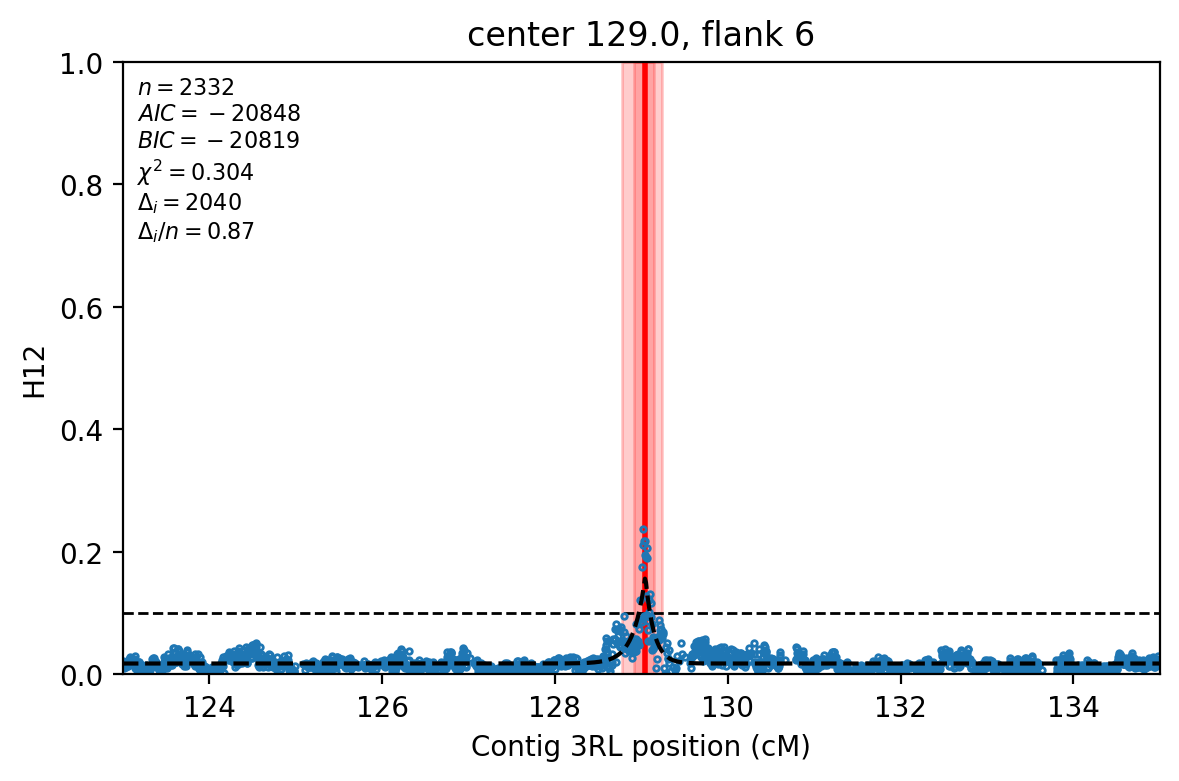

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 148
    # data points      = 2332
    # variables        = 5
    chi-square         = 0.30430054
    reduced chi-square = 1.3077e-04
    Akaike info crit   = -20847.9233
    Bayesian info crit = -20819.1509
[[Variables]]
    center:     129.046857 +/- 0.00270989 (0.00%) (init = 129)
    amplitude:  0.14294346 +/- 0.00341104 (2.39%) (init = 0.5)
    decay:      0.11540663 +/- 0.00428903 (3.72%) (init = 0.5)
    skew:       0.23673034 +/- 0.05286848 (22.33%) (init = 0)
    baseline:   0.01782655 +/- 2.4484e-04 (1.37%) (init = 0.01640945)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     =  0.689
    C(amplitude, decay) = -0.658
    C(decay, skew)      = -0.220
    C(decay, baseline)  = -0.170
    C(center, decay)    = -0.104


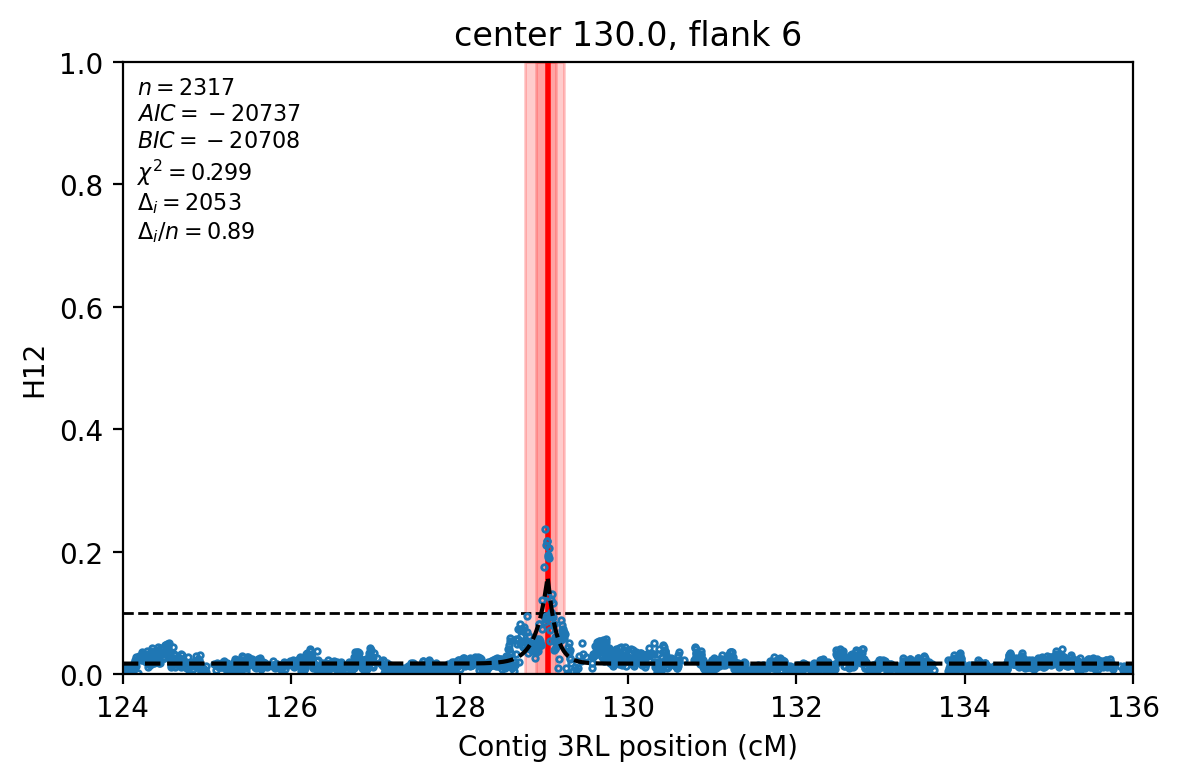

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 155
    # data points      = 2317
    # variables        = 5
    chi-square         = 0.29938204
    reduced chi-square = 1.2949e-04
    Akaike info crit   = -20736.5647
    Bayesian info crit = -20707.8246
[[Variables]]
    center:     129.046884 +/- 0.00270942 (0.00%) (init = 130)
    amplitude:  0.14277253 +/- 0.00338489 (2.37%) (init = 0.5)
    decay:      0.11613150 +/- 0.00428820 (3.69%) (init = 0.5)
    skew:       0.23720941 +/- 0.05252543 (22.14%) (init = 0)
    baseline:   0.01769758 +/- 2.4453e-04 (1.38%) (init = 0.01640945)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)      =  0.689
    C(amplitude, decay)  = -0.657
    C(decay, skew)       = -0.221
    C(decay, baseline)   = -0.171
    C(center, decay)     = -0.104
    C(center, amplitude) = -0.100


,cohort_id,contig,gcenter,pcenter,delta_i,stat_max,gpos_max,ppos_max,focus_gstart,focus_gstop,...,amplitude,decay,skew,decay_left,decay_right,baseline,aic,bic,rss,constant_aic
0,llineup,3RL,49.830308,24915154,535,0.112037,49.813746,24906873,49.711901,49.889511,...,0.030000,1.674521,0.500000,2.368130,1.184065,0.019626,-20627.381401,-20598.519743,0.398219,-20091.546839
1,llineup,3RL,58.490216,29245108,534,0.112581,58.491468,29245734,58.474247,58.498200,...,0.048440,0.225834,0.500000,0.319378,0.159689,0.023545,-21281.001692,-21251.949928,0.438907,-20746.863772
2,llineup,3RL,129.046857,67929179,2039,0.237200,129.019442,67915471,129.040058,129.051754,...,0.142943,0.115407,0.236730,0.135986,0.097942,0.017827,-20847.923330,-20819.150923,0.304301,-18808.184026
3,llineup,3RL,129.046884,67929193,2052,0.237200,129.019442,67915471,129.040040,129.051811,...,0.142773,0.116131,0.237209,0.136885,0.098524,0.017698,-20736.564738,-20707.824595,0.299382,-18683.788230


In [17]:
# set up results
results = []

# main loop, iterate along the genome
for gcenter in np.arange(scan_start, scan_stop, scan_interval):

    for gflank in h12_signal_detection_gflanks:

        # print('center', gcenter, 'flank size', gflank)

        result = fit_exponential_peak(
            ppos=ppos, 
            gpos=gpos, 
            stat_filtered=h12_filtered, 
            gcenter=gcenter, 
            gflank=gflank, 
            scan_interval=scan_interval,
            init_amplitude=init_amplitude,
            min_amplitude=min_amplitude,
            max_amplitude=max_amplitude,
            init_decay=init_decay,
            min_decay=min_decay,
            init_skew=init_skew,
            min_skew=min_skew,
            max_skew=max_skew,
            init_baseline=init_baseline,
            min_baseline=min_baseline,
            max_baseline=max_baseline,
            min_delta_aic=h12_signal_detection_min_delta_aic,
            min_stat_max=h12_signal_detection_min_stat_max,
            debug=debug,
        )

        if result is not None:
            results.append(result)

df_signals = pd.DataFrame.from_records(results)
df_signals

In [ ]:
df_signals

In [18]:
def dedup_signals(df_signals):
    
    keep = list(range(len(df_signals)))
    for i, this in df_signals.iterrows():
        for j, that in df_signals.iterrows():
            if i != j:
                # thank you Ned Batchelder
                # https://nedbatchelder.com/blog/201310/range_overlap_in_two_compares.html
                disjoint = that.span1_gstart > this.span1_gstop or that.span1_gstop < this.span1_gstart
                if not disjoint and that.delta_i > this.delta_i:
                    keep.remove(i)
                    break
    return df_signals.iloc[keep].copy()


In [19]:
df_signals_dedup = dedup_signals(df_signals)
df_signals_dedup

,cohort_id,contig,gcenter,pcenter,delta_i,stat_max,gpos_max,ppos_max,focus_gstart,focus_gstop,...,amplitude,decay,skew,decay_left,decay_right,baseline,aic,bic,rss,constant_aic
0,llineup,3RL,49.830308,24915154,535,0.112037,49.813746,24906873,49.711901,49.889511,...,0.030000,1.674521,0.500000,2.368130,1.184065,0.019626,-20627.381401,-20598.519743,0.398219,-20091.546839
1,llineup,3RL,58.490216,29245108,534,0.112581,58.491468,29245734,58.474247,58.498200,...,0.048440,0.225834,0.500000,0.319378,0.159689,0.023545,-21281.001692,-21251.949928,0.438907,-20746.863772
3,llineup,3RL,129.046884,67929193,2052,0.237200,129.019442,67915471,129.040040,129.051811,...,0.142773,0.116131,0.237209,0.136885,0.098524,0.017698,-20736.564738,-20707.824595,0.299382,-18683.788230


## Write outputs

In [20]:
outdir= "/home/namulil/lstm_projects/funestus_llineup/notebooks/Signal_localisation"
os.makedirs(outdir, exist_ok=True)
with open(os.path.join(outdir, f"{cohort_id}_{contig}.csv"), mode="w") as output_file:
    df_signals_dedup.to_csv(output_file, index=False)